In [103]:
### Script to compare the different viscosity ratios 

from datetime import datetime
import pandas as pd
import os 
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.patches as mpatches
from matplotlib import cm



In [8]:
drainage = pd.read_excel(
    r'ganglia.xlsx',
    sheet_name='Drainage',
    engine='openpyxl'
)

# Read "Imbibition" sheet
imbibition = pd.read_excel(
    r'ganglia.xlsx',
    sheet_name='Imbibition',
    engine='openpyxl'
)



### Code for analysis

In [136]:
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

def convert_units(data, voxel_size, volume_col, area_col, z_col):
    "conversion of values from voxels to microns, if needed"
    data[volume_col] = data[volume_col] * (voxel_size ** 3) / 1e9
    data[area_col] = data[area_col] * (voxel_size ** 2) / 1e6
    data[z_col] = data[z_col] * voxel_size / 1000
    return data

def cumulative_count(data):
    return np.arange(1, len(data)+1)

def ganglia_analysis(data, color, voxel_size = 1, offset = 0):
    '''voxel_size in microns to convert values from voxels to microns'''
    data = data.copy()

    max_size = 10**11 #filtering events for the analysis this is in voxels 
    min_size = 10**-11
    num_bins = 20 #spacing for histogram 
    bins = np.linspace(1, 40, num_bins)

   
    ## making code robust to Avizo changing whether there is a capital letter after 3D or not. I hate Avizo
    col_map = {col.strip().lower(): col for col in data.columns}

    # Find actual column names, case-insensitively
    volume_col   = col_map.get('volume3d')
    area_col     = col_map.get('area3d')
    first_pointz = col_map.get('firstpointz')
    
    if volume_col is None or area_col is None:
        raise ValueError("Data must contain 'Volume3D' and 'Area3D' columns (case-insensitive).")

    #filtered data
    filtered_data_global = data[(data[volume_col] < max_size) & (data[volume_col] > min_size)]
    filtered_data_global = convert_units(filtered_data_global, voxel_size, volume_col, area_col, first_pointz)

    print('Max starting point', np.max(filtered_data_global[first_pointz]))    

    # plot of ganglia size vs distance from the inlet for final timestep
    plt.figure(1)
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    plt.semilogy(filtered_data_global[first_pointz], filtered_data_global[volume_col] , 'x', color = color)
    plt.ylabel('Ganglion size (mm$^3$)')
    plt.xlabel('Distance of ganglion initialization from inlet (mm)')
    plt.title('Location of the ganglia')

    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    plt.hist(filtered_data_global[first_pointz], bins=bins, edgecolor='k', color = color, alpha = 0.5) 
    plt.xlabel('Distance of ganglion initialization from inlet (mm)')
    plt.ylabel('Number of ganglia')
    plt.title('Number of ganglia for each location')
    plt.tight_layout()

    plt.figure(2, figsize=(12, 12))
    for i in range(len(bins)-1):     
            filtered_data_bin            = filtered_data_global[(filtered_data_global[first_pointz] > bins[i]) & (filtered_data_global[first_pointz] < bins[i+1])]
            
            volume_ganglia_interval      = filtered_data_bin[volume_col].sum()
            width_bin = (bins[i+1] - bins[i]) * 0.5
            
            plt.subplot(3, 2, 1)
            plt.bar(bins[i] - offset , volume_ganglia_interval, width= width_bin, edgecolor='k', color = color, alpha=0.8)
            plt.ylabel('Sum volume for interval (mm$^3$)')
            plt.xlabel('Start of ganglion (mm)')

            distinct_ganglia =  len(filtered_data_bin[volume_col])
            plt.subplot(3, 2, 2)
            plt.bar(bins[i] - offset, distinct_ganglia, width= width_bin, edgecolor='k', color = color, alpha=0.8)
            plt.ylabel('Number of ganglia in interval')
            plt.xlabel('Start of ganglion (mm)')

            mean_ganglia_interval = np.mean(filtered_data_bin[volume_col])
            plt.subplot(3, 2, 3)
            plt.bar(bins[i] - offset, mean_ganglia_interval, width= width_bin, edgecolor='k', color = color, alpha=0.8)
            plt.ylabel('Mean volume for interval')
            plt.xlabel('Start of ganglion (mm)')

            plt.subplot(3, 2, 4)
            plt.bar(bins[i] - offset,mean_ganglia_interval/ volume_ganglia_interval, width= width_bin, edgecolor='k', color = color, alpha=0.8)
            plt.ylabel('Weighted volume for interval')
            plt.xlabel('Start of ganglion (mm)')

    plt.subplots_adjust(right=0.8)
    drainage_patch = mpatches.Patch(color  = cm.tab10(0), label='Drainage')
    imbibition_patch = mpatches.Patch(color=cm.tab10(1), label='Imbibition')
    plt.legend(handles=[drainage_patch, imbibition_patch], loc='upper right', bbox_to_anchor=(1.4, 1), borderaxespad=0, frameon=False)
    plt.tight_layout()

    sorted_volumes = np.sort(filtered_data_global[volume_col])
    cdf = np.arange(1, len(sorted_volumes) + 1) / len(sorted_volumes)

    plt.figure(3, figsize=(9, 6))
    plt.plot(sorted_volumes, cdf, color=color, linewidth=2)
    plt.xlabel('Ganglion volume (mm$^3$)')
    plt.xscale('log')
    plt.ylabel('Cumulative probability')
    plt.title('Cumulative distribution of ganglion volumes')
    plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.7)


    plt.figure(4, figsize=(9, 6))
    plt.plot(sorted_volumes, cumulative_count(sorted_volumes)[::-1], color=color)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Ganglia Volume (mm$^3$)")
    plt.ylabel("Cumulative Count of Ganglia > Volume")
    plt.title("Ganglia Size Distribution")
    plt.grid(True, which="both", ls="--", lw=0.5, alpha=0.6)


### Analysis

Max starting point 42.492799999999995
Max starting point 28.806399999999996


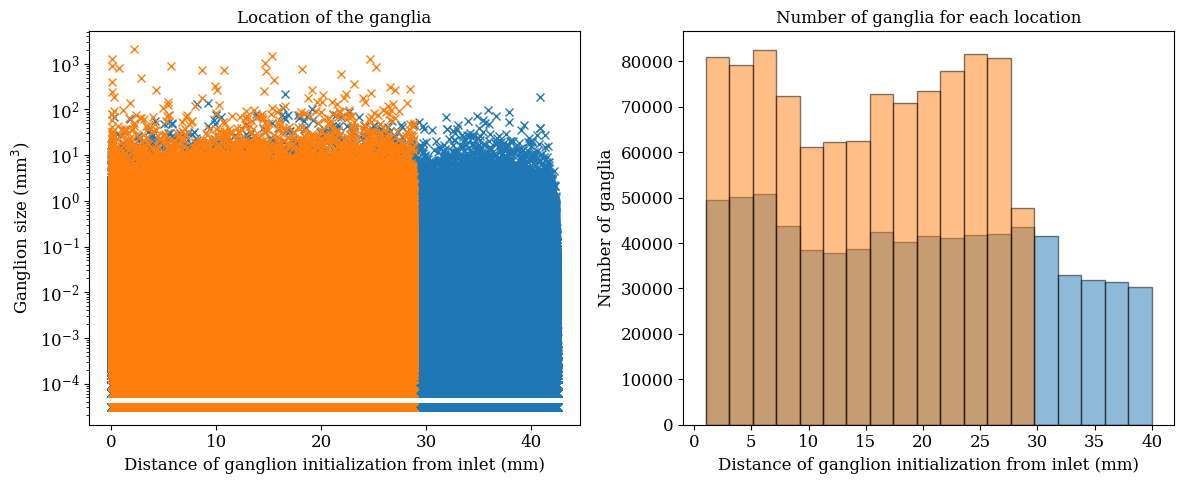

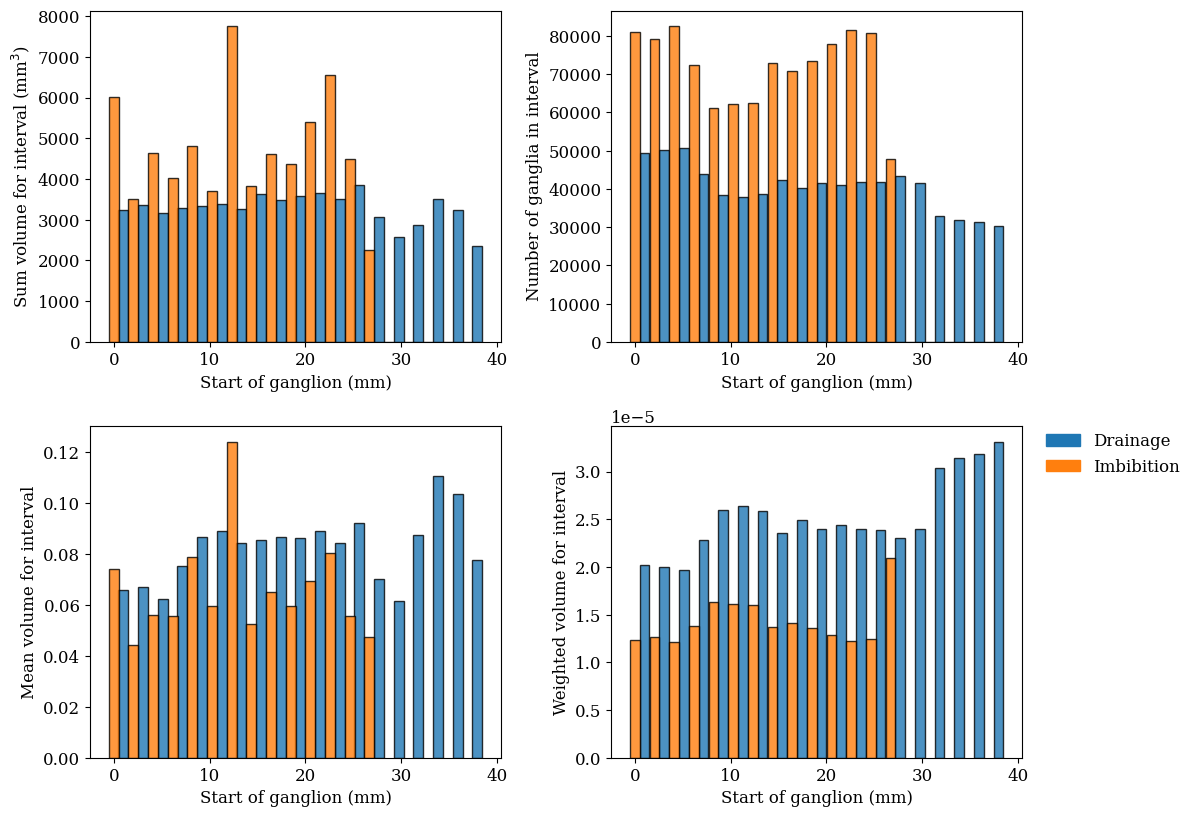

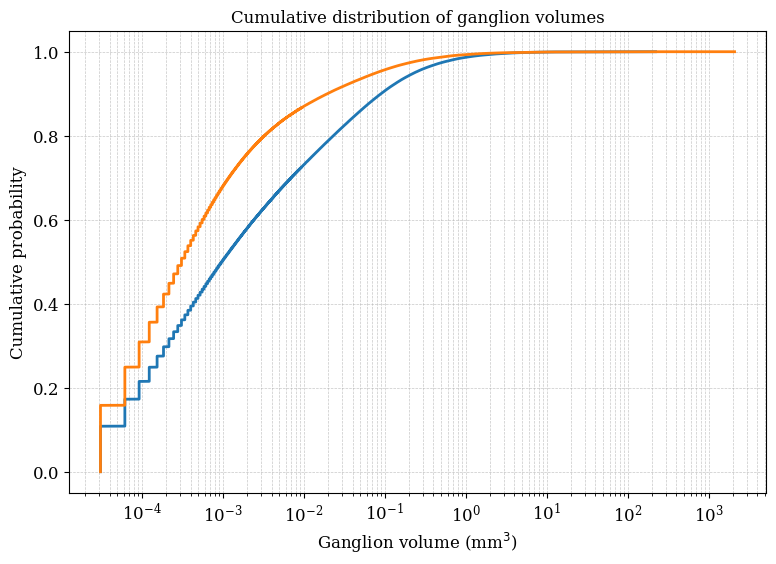

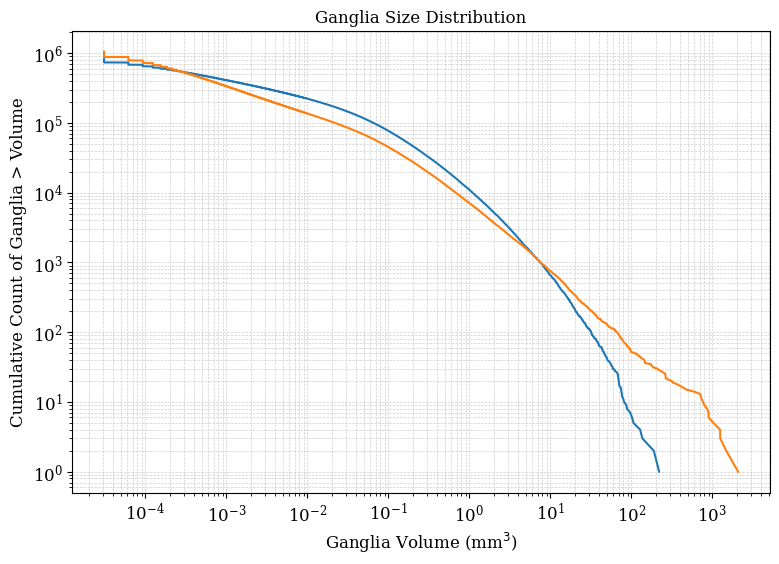

In [137]:


plt.figure(1, figsize=(12, 5)) 
ganglia_analysis(drainage,   color = cm.tab10(0), voxel_size = 5.6)

ganglia_analysis(imbibition, color = cm.tab10(1), voxel_size = 5.6, offset=1)
plt.show()
